# Evaluating Regression and Regularized Regression with the Automobile Dataset 
- This notebook implements a complete workflow for evaluating and comparing multiple regression models—specifically, Ordinary Least Squares (OLS), Ridge, Lasso, and Elastic Net—using the UCI Automobile dataset.  
- Each code cell has been annotated with a descriptive paragraph comment explaining the logic, purpose, and alignment of the code with the overall project goal: to analyze, preprocess, train, validate, and compare regression models for automobile price prediction.


In [26]:
__author__ = "Will Hinton"
__email__ = "willhint@gmail.com"
__website__ = "whinton0.github.com/py"

## Part 1 — Load Automobile dataset (imports-85.data) 
- This cell loads the dataset and performs the initial data import step.
- It defines column names, reads the CSV file using pandas, and prints basic information about the dataset.
- This step establishes the foundation for analysis by ensuring the dataset is available in a structured DataFrame.

In [27]:
# Part 1 — Load Automobile dataset (imports-85.data)
import pandas as pd
import numpy as np
from pathlib import Path

DATA_PATH = Path('./imports-85.data')
cols = [
    'symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors',
    'body-style','drive-wheels','engine-location','wheel-base','length','width','height',
    'curb-weight','engine-type','num-of-cylinders','engine-size','fuel-system','bore',
    'stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price'
]

df_raw = pd.read_csv(DATA_PATH, names=cols, na_values='?')
print('Shape:', df_raw.shape)
df_raw.head()


Shape: (205, 26)


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


## Part 2 - EDA and Preprocessing 
- This code performs exploratory data analysis (EDA) and prepares preprocessing pipelines.
- It explores missing values, data types, and correlations among features.
- It also defines transformation pipelines for numeric and categorical data using imputation, scaling, and encoding.
- These transformations are assembled in a ColumnTransformer, which ensures consistent preprocessing.

,normalized-losses,price,stroke,bore,peak-rpm,num-of-doors,horsepower,engine-type,highway-mpg,city-mpg,...,width,length,wheel-base,engine-location,drive-wheels,body-style,aspiration,fuel-type,make,curb-weight
missing_count,41,4,4,4,2,2,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
dtype,int64,float64,object,object,object,object,object,object,object,float64,...,int64,object,float64,float64,float64,float64,float64,int64,int64,float64


Numeric features: 15
Categorical features: 10


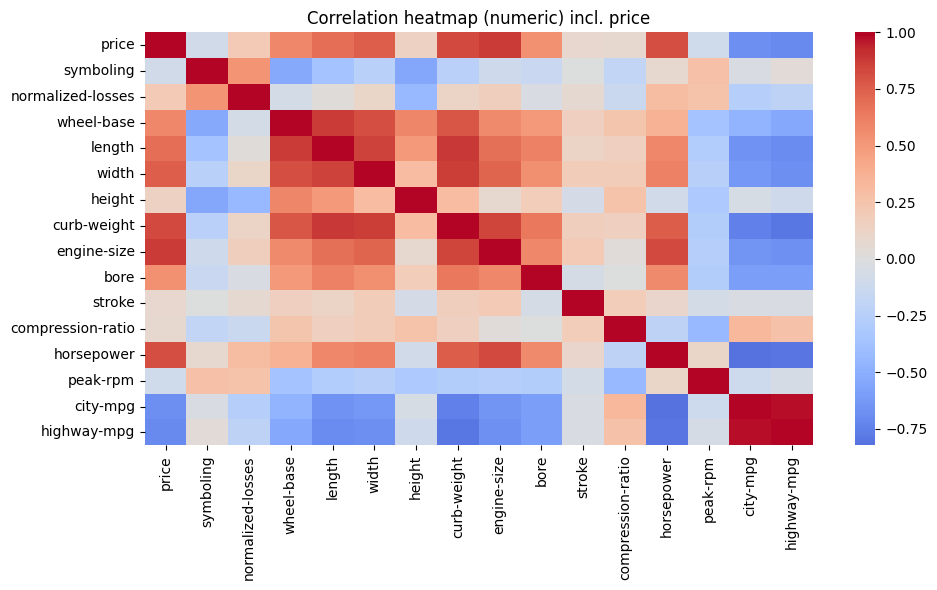

In [28]:
# Part 2 — EDA + Preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

eda_missing = df_raw.isna().sum().sort_values(ascending=False)
display(eda_missing.to_frame('missing_count').T)
display(df_raw.dtypes.to_frame('dtype').T)

df = df_raw.dropna(subset=['price']).copy()
df['price'] = pd.to_numeric(df['price'])

numeric_cols = [c for c in df.columns if c != 'price' and pd.api.types.is_numeric_dtype(df[c])]
categorical_cols = [c for c in df.columns if c != 'price' and c not in numeric_cols]
print('Numeric features:', len(numeric_cols))
print('Categorical features:', len(categorical_cols))

plt.figure(figsize=(10,6))
sns.heatmap(df[['price'] + numeric_cols].corr(numeric_only=True), cmap='coolwarm', center=0)
plt.title('Correlation heatmap (numeric) incl. price')
plt.tight_layout(); plt.show()

numeric_pre = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_pre = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_pre, numeric_cols), ('cat', categorical_pre, categorical_cols)])


## Part 3 - 70/30 Split 
- This cell splits the dataset into training and testing subsets.
- 70% of the data is used for training and 30% for testing, ensuring fair model evaluation.
- The target variable (price) is separated from the feature matrix.

In [29]:
# Part 3 — 70/30 Split
from sklearn.model_selection import train_test_split

X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)
auto_train = X_train.copy(); auto_train['price'] = y_train
auto_test = X_test.copy()  # test dataframe excludes target price
auto_train.shape, auto_test.shape


((140, 26), (61, 25))

## Part 4 — Build & Apply Models (OLS, Ridge, Lasso, Elastic Net) 
- This code builds four regression model pipelines—OLS, Ridge, Lasso, and Elastic Net.
- Each model is combined with the preprocessor to ensure consistent data transformation.
- After fitting, models are stored for later evaluation, and predictions on the test set are generated.

In [30]:
# Part 4 — Build & Apply Models (OLS, Ridge, Lasso, Elastic Net)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline

models = {
    'OLS': Pipeline(steps=[('prep', preprocessor), ('model', LinearRegression())]),
    'Ridge': Pipeline(steps=[('prep', preprocessor), ('model', Ridge(alpha=1.0, random_state=42))]),
    'Lasso': Pipeline(steps=[('prep', preprocessor), ('model', Lasso(alpha=0.001, random_state=42, max_iter=50000, tol=0.01))]),
    'ElasticNet': Pipeline(steps=[('prep', preprocessor), ('model', ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=50000, tol=0.01))])
}

fitted_models = {}
test_predictions = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    fitted_models[name] = pipe
    test_predictions[name] = pipe.predict(X_test)
    print(f'Fitted {name}.')


Fitted OLS.
Fitted Ridge.
Fitted Lasso.
Fitted ElasticNet.


## Part 5 - Feature Importance and Model Coefficients 
- Extract feature names after preprocessing (get_feature_names_out() handles one-hot encoding).
- Retrieve model coefficients (coef_).
- Create a sorted DataFrame for each model.
- Display top / bottom coefficients as tables and horizontal bar charts.


=== OLS Coefficients ===


,Feature,Coefficient
59,cat__num-of-cylinders_eight,15554.1465
17,cat__make_bmw,5753.9407
22,cat__make_jaguar,5123.1860
52,cat__engine-location_rear,4363.5395
30,cat__make_porsche,4363.5395
6,num__curb-weight,3964.9440
16,cat__make_audi,3269.6670
56,cat__engine-type_ohcf,2573.8591
43,cat__body-style_convertible,2323.8168
32,cat__make_saab,2253.0742


,Feature,Coefficient
36,cat__make_volvo,-2181.1342
57,cat__engine-type_ohcv,-2412.3165
29,cat__make_plymouth,-2598.5424
19,cat__make_dodge,-2881.4618
25,cat__make_mercury,-3602.9368
62,cat__num-of-cylinders_six,-3777.7239
21,cat__make_isuzu,-3904.4736
51,cat__engine-location_front,-4363.5395
61,cat__num-of-cylinders_four,-4687.8641
60,cat__num-of-cylinders_five,-5298.5211


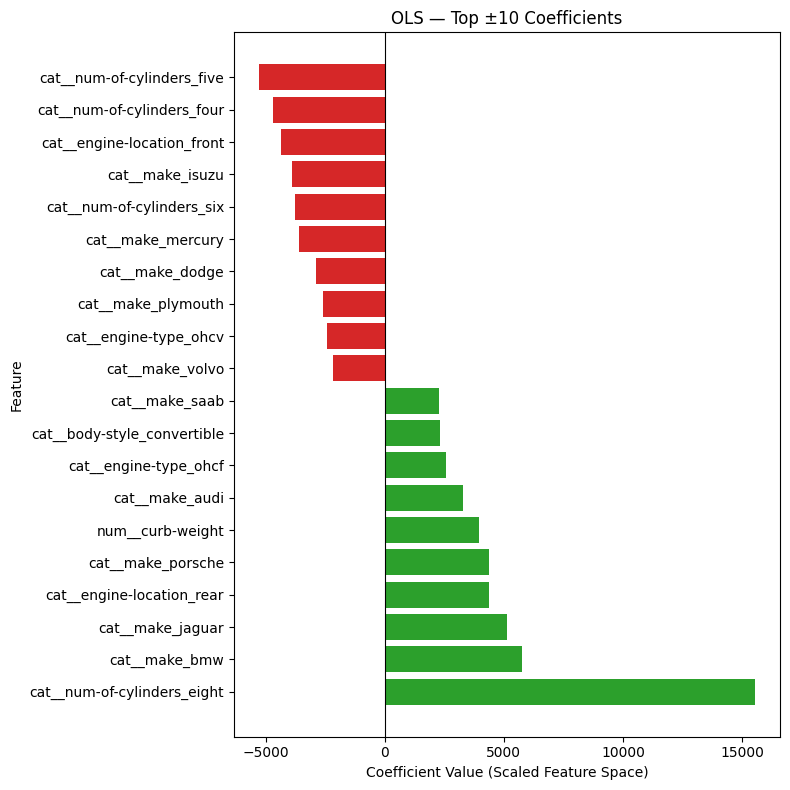


=== Ridge Coefficients ===


,Feature,Coefficient
59,cat__num-of-cylinders_eight,4164.4021
17,cat__make_bmw,3788.6071
7,num__engine-size,3053.3942
30,cat__make_porsche,2560.9281
52,cat__engine-location_rear,2560.9281
24,cat__make_mercedes-benz,2449.5780
43,cat__body-style_convertible,1896.6069
6,num__curb-weight,1719.9521
2,num__wheel-base,1229.2269
56,cat__engine-type_ohcf,1118.2816


,Feature,Coefficient
62,cat__num-of-cylinders_six,-1331.0407
33,cat__make_subaru,-1442.6465
60,cat__num-of-cylinders_five,-1468.7387
34,cat__make_toyota,-1538.3668
19,cat__make_dodge,-1637.1866
28,cat__make_peugot,-1640.0754
29,cat__make_plymouth,-1677.4380
57,cat__engine-type_ohcv,-1778.9995
61,cat__num-of-cylinders_four,-1911.7214
51,cat__engine-location_front,-2560.9281


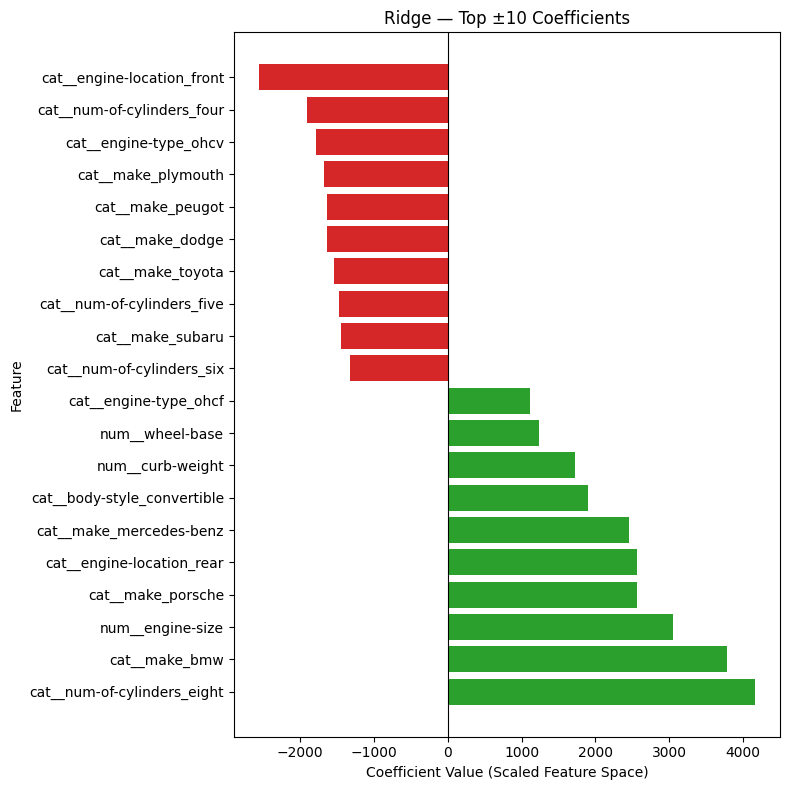


=== Lasso Coefficients ===


,Feature,Coefficient
59,cat__num-of-cylinders_eight,19332.9216
30,cat__make_porsche,14269.1855
17,cat__make_bmw,6674.8121
22,cat__make_jaguar,6042.0647
16,cat__make_audi,4190.6073
6,num__curb-weight,3964.9319
63,cat__num-of-cylinders_three,3715.1770
32,cat__make_saab,3173.8868
43,cat__body-style_convertible,3014.9369
64,cat__num-of-cylinders_twelve,2845.9979


,Feature,Coefficient
66,cat__fuel-system_1bbl,-1541.8198
29,cat__make_plymouth,-1678.2645
49,cat__drive-wheels_fwd,-1713.9472
39,cat__aspiration_std,-1774.2952
19,cat__make_dodge,-1961.1030
54,cat__engine-type_l,-2139.4359
48,cat__drive-wheels_4wd,-2606.5412
25,cat__make_mercury,-2681.5161
21,cat__make_isuzu,-2984.1470
57,cat__engine-type_ohcv,-3188.7171


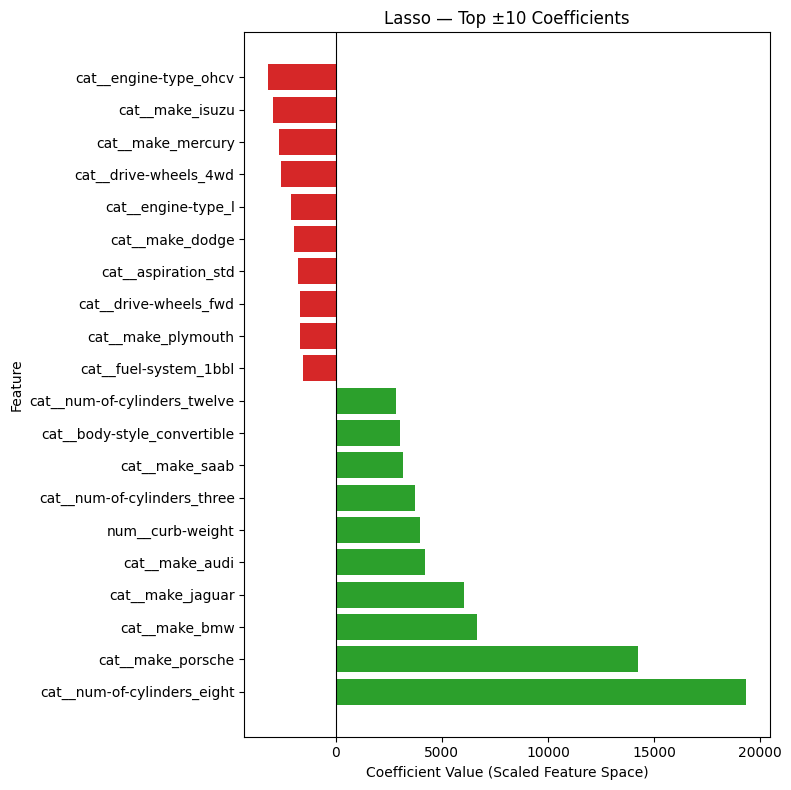


=== ElasticNet Coefficients ===


,Feature,Coefficient
59,cat__num-of-cylinders_eight,4945.3477
17,cat__make_bmw,4253.4611
7,num__engine-size,2928.6054
52,cat__engine-location_rear,2919.0480
30,cat__make_porsche,2919.0261
24,cat__make_mercedes-benz,2539.7221
43,cat__body-style_convertible,2029.1031
6,num__curb-weight,2023.4231
16,cat__make_audi,1434.3090
56,cat__engine-type_ohcf,1331.0526


,Feature,Coefficient
33,cat__make_subaru,-1587.0128
62,cat__num-of-cylinders_six,-1606.8788
34,cat__make_toyota,-1615.2483
28,cat__make_peugot,-1778.0665
57,cat__engine-type_ohcv,-1911.4344
60,cat__num-of-cylinders_five,-1918.4706
19,cat__make_dodge,-1920.7071
61,cat__num-of-cylinders_four,-1922.4553
29,cat__make_plymouth,-1929.7886
51,cat__engine-location_front,-2919.0408


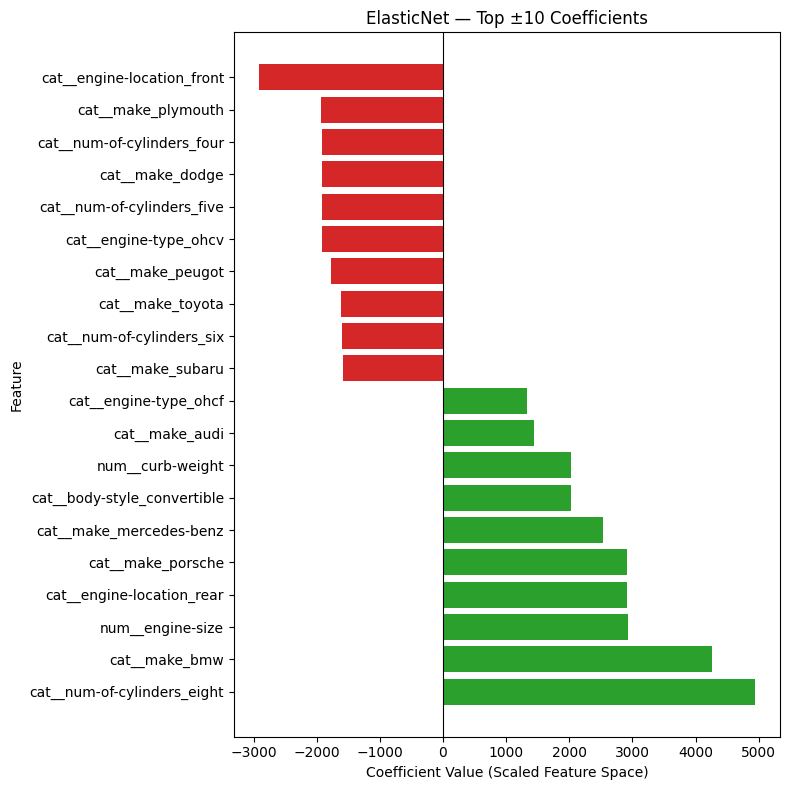

In [31]:
# Part 5 — Feature Importance and Model Coefficients
# ---------------------------------------------------
# This section extracts and visualizes learned feature coefficients for each fitted linear model.
# For models that include regularization (Ridge, Lasso, ElasticNet),
# coefficients closer to zero indicate less influence on the prediction.
# Lasso may zero-out some coefficients entirely (feature selection).

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_top_coefficients(pipe, model_name, top_n=15):
    """Extract and plot the top positive and negative coefficients from a fitted pipeline."""
    # Get processed feature names from the preprocessor
    feature_names = pipe.named_steps['prep'].get_feature_names_out()
    coefs = pipe.named_steps['model'].coef_

    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs
    }).sort_values(by='Coefficient', ascending=False)

    # Display the coefficient table (sorted)
    print(f"\n=== {model_name} Coefficients ===")
    display(coef_df.round(4).head(10))
    display(coef_df.round(4).tail(10))

    # Plot top-N positive and negative coefficients
    plt.figure(figsize=(8, 8))
    top_features = pd.concat([coef_df.head(top_n), coef_df.tail(top_n)])
    colors = ['#2ca02c' if c > 0 else '#d62728' for c in top_features['Coefficient']]

    plt.barh(top_features['Feature'], top_features['Coefficient'], color=colors)
    plt.title(f"{model_name} — Top ±{top_n} Coefficients")
    plt.xlabel("Coefficient Value (Scaled Feature Space)")
    plt.ylabel("Feature")
    plt.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()

# Loop through each fitted model and visualize coefficients
for name, pipe in fitted_models.items():
    plot_top_coefficients(pipe, name, top_n=10)

## Part 6 — Evaluation with 5-fold CV (RMSE, MAE, R^2) 
- This cell evaluates each model using 5-fold cross-validation.
- It computes RMSE, MAE, and R² metrics to assess prediction accuracy, average absolute error, and variance explained.
- Results are stored in DataFrames for later comparison.

In [32]:
# Part 6 — Evaluation with 5-fold CV (RMSE, MAE, R^2)
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd


cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results, holdout_results = [], []
for name, pipe in fitted_models.items():
    neg_rmse = cross_val_score(pipe, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)
    neg_mae = cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv)
    r2 = cross_val_score(pipe, X_train, y_train, scoring='r2', cv=cv)
    cv_results.append({'Model': name, 'CV_RMSE': -neg_rmse.mean(), 'CV_MAE': -neg_mae.mean(), 'CV_R2': r2.mean()})
    y_pred = test_predictions[name]
    holdout_results.append({'Model': name, 'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred)), 'Test_MAE': mean_absolute_error(y_test, y_pred), 'Test_R2': r2_score(y_test, y_pred)})
cv_df = pd.DataFrame(cv_results).set_index('Model')
test_df = pd.DataFrame(holdout_results).set_index('Model')
display(cv_df.round(3)); display(test_df.round(3))


,CV_RMSE,CV_MAE,CV_R2
Model,,,
OLS,3352.698,2131.310,0.717
Ridge,2614.824,1799.738,0.835
Lasso,3597.913,2153.494,0.676
ElasticNet,2668.003,1801.269,0.829


,Test_RMSE,Test_MAE,Test_R2
Model,,,
OLS,2907.333,1730.373,0.911
Ridge,2593.659,1691.373,0.929
Lasso,3160.892,1932.152,0.895
ElasticNet,2516.116,1654.619,0.933


## Part 7 — Hyperparameter Tuning (GridSearchCV) 
- This cell tunes hyperparameters for Ridge, Lasso, and Elastic Net using grid search with cross-validation.
- It searches across predefined ranges of alpha and l1_ratio values to identify the combination minimizing RMSE.

In [33]:
# Part 7 — Hyperparameter Tuning (GridSearchCV)
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grids = {
    'Ridge': {'model__alpha': np.logspace(-4, 3, 20)},
    'Lasso': {'model__alpha': np.logspace(-4, 1, 20)},
    'ElasticNet': {'model__alpha': np.logspace(-4, 1, 10), 'model__l1_ratio': np.linspace(0.1, 0.9, 9)}
}

best_models, search_results = {}, {}
for name in ['Ridge','Lasso','ElasticNet']:
    pipe = models[name]
    grid = GridSearchCV(estimator=pipe, param_grid=param_grids[name], scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    search_results[name] = {'best_params': grid.best_params_, 'best_cv_rmse': -grid.best_score_}
    print(name, 'best params:', grid.best_params_)
    print(name, 'best CV RMSE:', -grid.best_score_)
best_models['OLS'] = models['OLS']


Ridge best params: {'model__alpha': 6.1584821106602545}
Ridge best CV RMSE: 2637.871120638496
Lasso best params: {'model__alpha': 10.0}
Lasso best CV RMSE: 2958.676267382808
ElasticNet best params: {'model__alpha': 0.05994842503189409, 'model__l1_ratio': 0.30000000000000004}
ElasticNet best CV RMSE: 2635.450516981052


## Part 8 — Comparative Table + Visualization (separate R² plot) 
- This cell visualizes the model performance metrics in a comparative table and bar plots.
- RMSE and MAE are compared in one figure; R² is plotted separately for clarity.

,RMSE (CV),MAE (CV),R^2 (CV)
Model,,,
OLS,3352.698,2131.310,0.717
Ridge,2614.824,1799.738,0.835
Lasso,3597.913,2153.494,0.676
ElasticNet,2668.003,1801.269,0.829


<Figure size 1000x600 with 0 Axes>

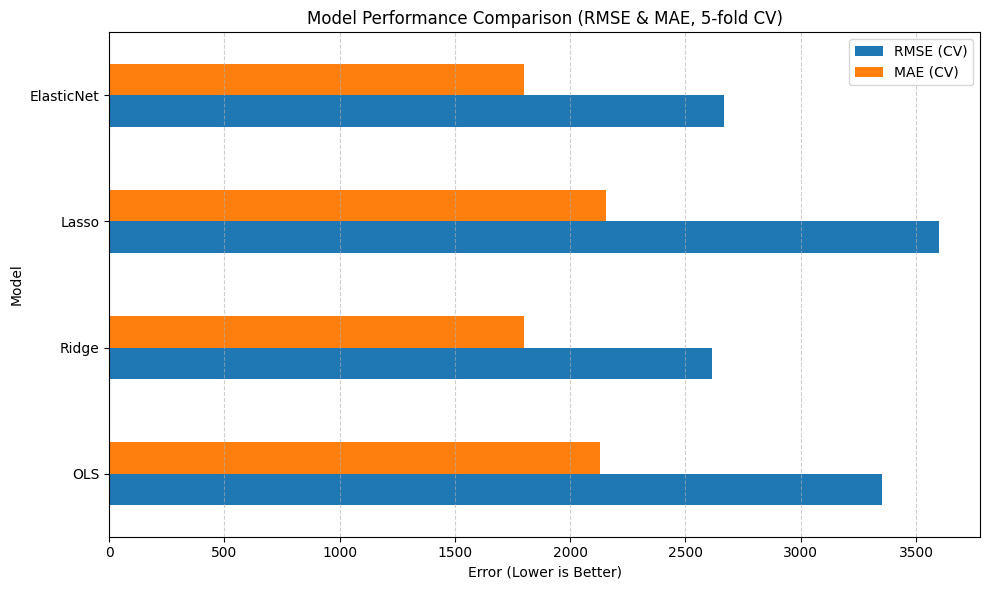

<Figure size 800x400 with 0 Axes>

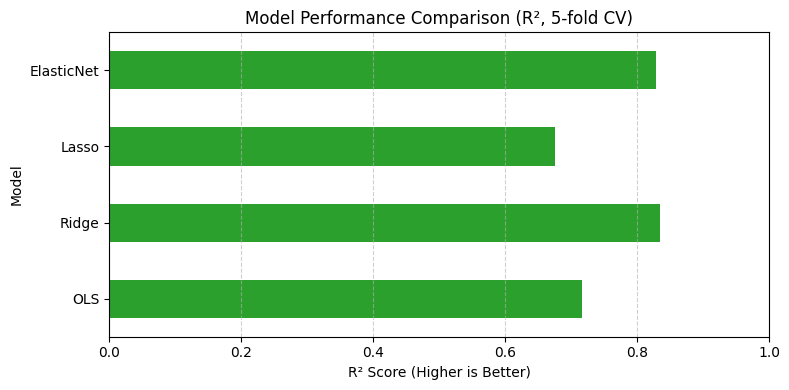

In [34]:
# Part 8 — Comparative Table + Visualization (separate R² plot)
import matplotlib.pyplot as plt
import pandas as pd

# Prepare comparison table
comparison = cv_df.copy()
comparison.columns = ['RMSE (CV)', 'MAE (CV)', 'R^2 (CV)']
display(comparison.round(3))

# --- Plot 1: RMSE & MAE (on the same scale) ---
plt.figure(figsize=(10,6))
comparison[['RMSE (CV)', 'MAE (CV)']].plot(
    kind='barh', figsize=(10,6), color=['#1f77b4', '#ff7f0e']
)
plt.title('Model Performance Comparison (RMSE & MAE, 5-fold CV)')
plt.xlabel('Error (Lower is Better)')
plt.ylabel('Model')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Plot 2: R² only (different scale) ---
plt.figure(figsize=(8,4))
comparison[['R^2 (CV)']].plot(
    kind='barh', figsize=(8,4), color=['#2ca02c'], legend=False
)
plt.title('Model Performance Comparison (R², 5-fold CV)')
plt.xlabel('R² Score (Higher is Better)')
plt.ylabel('Model')
plt.xlim(0, 1)  # optional if all R² are within [0, 1]
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Part 9 — Save CSVs and Qualitative Comparison Table 
- This cell exports processed data (train/test) and builds a qualitative comparison summary.
- The summary lists model purposes, benefits, limitations, and real-world use cases. 
- The commentary emphasizes regularization benefits, model stability, and interpretability.

In [35]:
# Part 9 — Save CSVs + Qualitative Comparison Table
from pathlib import Path
OUT_DIR = Path('.')
best_name = min(search_results, key=lambda k: search_results[k]['best_cv_rmse'])
best_pipe = best_models[best_name]
best_test_pred = best_pipe.predict(X_test)
auto_test_out = auto_test.copy(); auto_test_out['predicted_price'] = best_test_pred
auto_train.to_csv(OUT_DIR/'auto_train.csv', index=False)
auto_test_out.to_csv(OUT_DIR/'auto_test.csv', index=False)
print('Saved auto_train.csv and auto_test.csv')

summary_rows = [
    {'Model':'OLS','Purpose':'Baseline linear regression without regularization','Key Benefits':'Simple, interpretable coefficients; fast to fit','Key Limitations':'Unstable with multicollinearity; prone to overfitting','Regularization’s Role in Model Selection':'None (baseline comparator)','Top-3 Real-World Use-Cases':'Automobile pricing; Housing prices; Sales forecasting'},
    {'Model':'Ridge','Purpose':'L2-regularized linear regression (shrinkage)','Key Benefits':'Stabilizes coefficients under multicollinearity; reduces variance','Key Limitations':'No feature selection—keeps all variables','Regularization’s Role in Model Selection':'Alpha controls shrinkage; balances bias-variance','Top-3 Real-World Use-Cases':'Energy consumption; Insurance pricing; Demand forecasting'},
    {'Model':'Lasso','Purpose':'L1-regularized linear regression (sparsity)','Key Benefits':'Automatic feature selection; simpler models','Key Limitations':'May pick one from correlated group; risk of underfit if alpha large','Regularization’s Role in Model Selection':'Alpha tunes sparsity—higher => more zeros','Top-3 Real-World Use-Cases':'Automobile pricing; Credit risk modeling; Marketing mix'},
    {'Model':'Elastic Net','Purpose':'Hybrid L1+L2 regularized linear regression','Key Benefits':'Grouped selection; handles multicollinearity; balances sparsity/stability','Key Limitations':'Two hyperparameters to tune','Regularization’s Role in Model Selection':'Joint alpha & l1_ratio trade off L1/L2','Top-3 Real-World Use-Cases':'Gene selection; Automobile pricing; Property valuations'}
]
qual_table = pd.DataFrame(summary_rows); display(qual_table)


Saved auto_train.csv and auto_test.csv


,Model,Purpose,Key Benefits,Key Limitations,Regularization’s Role in Model Selection,Top-3 Real-World Use-Cases
0,OLS,Baseline linear regression without regularization,"Simple, interpretable coefficients; fast to fit",Unstable with multicollinearity; prone to over...,None (baseline comparator),Automobile pricing; Housing prices; Sales fore...
1,Ridge,L2-regularized linear regression (shrinkage),Stabilizes coefficients under multicollinearit...,No feature selection—keeps all variables,Alpha controls shrinkage; balances bias-variance,Energy consumption; Insurance pricing; Demand ...
2,Lasso,L1-regularized linear regression (sparsity),Automatic feature selection; simpler models,May pick one from correlated group; risk of un...,Alpha tunes sparsity—higher => more zeros,Automobile pricing; Credit risk modeling; Mark...
3,Elastic Net,Hybrid L1+L2 regularized linear regression,Grouped selection; handles multicollinearity; ...,Two hyperparameters to tune,Joint alpha & l1_ratio trade off L1/L2,Gene selection; Automobile pricing; Property v...
